In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sentimentanalysis/train.tsv
/kaggle/input/sentimentanalysistest/test.tsv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [2]:
df = pd.read_csv("/kaggle/input/sentimentanalysis/train.tsv",sep='\t')
df.head(100)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
95,96,3,", I suspect ,",2
96,97,3,"I suspect ,",2
97,98,3,I suspect,2
98,99,3,I,2


In [3]:
df.Phrase[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [4]:
df.Phrase[1]

'A series of escapades demonstrating the adage that what is good for the goose'

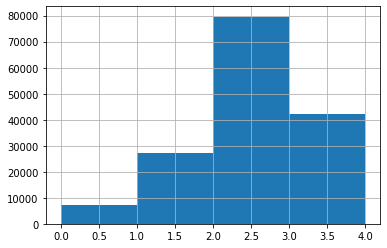

In [5]:
df['Sentiment'].hist(bins=4)

# Data engineering
### not much to do here : lemmatize, remove punctuation

In [34]:
import nltk
from nltk.corpus import stopwords
import string
stopSet = set(stopwords.words("english"))
porter = nltk.PorterStemmer()
WNlemma = nltk.WordNetLemmatizer()

processed_reviews = []
def process(phrase):
    words_az=phrase.lower().split() # list
    #words = [w for w in words_az if w not in stopSet]
    words_lem=[WNlemma.lemmatize(t) for t in words_az if t not in string.punctuation ]
    return " ".join(words_lem)





In [7]:
df['processed']=df["Phrase"].apply(process)


In [8]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,processed
0,1,1,A series of escapades demonstrating the adage ...,1,a series of escapade demonstrating the adage t...
1,2,1,A series of escapades demonstrating the adage ...,2,a series of escapade demonstrating the adage t...
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


# First model : RFClassifier with CountVect or TfIdf

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = CountVectorizer()
vect = TfidfVectorizer()
X = vect.fit_transform(df["processed"])
#X=X.toarray()

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,df["Sentiment"],test_size=0.2,random_state=12)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
model = RandomForestClassifier(n_estimators = 100)
#model = MultinomialNB()
model = model.fit( x_train,y_train)

In [12]:
from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score

pred = model.predict(x_test)
accuracy=accuracy_score(y_test,pred)
#roc_auc=roc_auc_score(y_test,pred)
print(classification_report(y_test,pred))
print("accuracy :",accuracy)


              precision    recall  f1-score   support

           0       0.44      0.36      0.40      1437
           1       0.54      0.45      0.49      5606
           2       0.69      0.82      0.75     15764
           3       0.56      0.45      0.50      6592
           4       0.50      0.38      0.43      1813

    accuracy                           0.63     31212
   macro avg       0.55      0.49      0.51     31212
weighted avg       0.61      0.63      0.62     31212

accuracy : 0.6279636037421504


# Second try : TRY LSTM
### Very useful alg for sequence modelling

In [20]:
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

Using TensorFlow backend.


In [26]:
from sklearn.model_selection import train_test_split
def tokenize(phrase):
    words = nltk.word_tokenize(phrase)
    return words
df['processed_tokens']=df["processed"].apply(tokenize)

target=df.Sentiment.values
y_target=to_categorical(target)
num_class=y_target.shape[1]

x_train,x_test,y_train,y_test=train_test_split(df["processed_tokens"],y_target,test_size=0.2,random_state=12)



In [27]:
# need to know the max size of the tokenized sentences for padding
unique_set_of_words =  set()
len_max = 0
for i in range(df.processed_tokens.shape[0]) :
    unique_set_of_words.update(df.processed_tokens[i])
    if len_max < len(df.processed_tokens[i]):
        len_max =len(df.processed_tokens[i])
print(len(list(unique_set_of_words)))
print(len_max)

15183
49


### KERAS Tokenizer

In [28]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

#Padding
x_train = sequence.pad_sequences(x_train, maxlen=len_max)
x_test = sequence.pad_sequences(x_test, maxlen=len_max)

print(x_train.shape,x_test.shape)

(124848, 49) (31212, 49)


### Model using Keras LSTM

Multilayer Perceptron (MLP) for multi-class softmax classification:
Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 

This architecture is specially designed to work on sequence data.

Don't have the ressources here to tune the model and increase accuracy. here is just an idea of model architecture


In [29]:
model=Sequential()
# Embedding layer : 
# vocabulary of len(list(unique_set_of_words)), size of the output vector 200, input_length =number of words in each phrase
# 
model.add(Embedding(len(list(unique_set_of_words)),200,input_length=len_max))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 49, 200)           3036600   
_________________________________________________________________
lstm_7 (LSTM)                (None, 49, 64)            67840     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 85        
Total params: 3,117,469
Trainable params: 3,117,469
Non-trainable params: 0
____________________________________________

In [30]:
classificator=model.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=6, batch_size=256, verbose=1
                        #, callbacks=callback
                       )

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 126s 1ms/step - loss: 1.0973 - accuracy: 0.5615 - val_loss: 0.8926 - val_accuracy: 0.6291
Epoch 2/6
124848/124848 [==============================] - 124s 997us/step - loss: 0.8932 - accuracy: 0.6368 - val_loss: 0.8465 - val_accuracy: 0.6432
Epoch 3/6
124848/124848 [==============================] - 123s 987us/step - loss: 0.8283 - accuracy: 0.6586 - val_loss: 0.8300 - val_accuracy: 0.6576
Epoch 4/6
124848/124848 [==============================] - 123s 988us/step - loss: 0.7947 - accuracy: 0.6689 - val_loss: 0.8325 - val_accuracy: 0.6621
Epoch 5/6
124848/124848 [==============================] - 124s 997us/step - loss: 0.7704 - accuracy: 0.6759 - val_loss: 0.8457 - val_accuracy: 0.6641
Epoch 6/6
124848/124848 [==============================] - 122s 979us/step - loss: 0.7507 - accuracy: 0.6843 - val_loss: 0.8502 - val_accuracy: 0.6644


### Check if early stopping is necessary 
### --> yes of course...
#### Maybe try another learning rate, use cross-validation (gridsearch), or add a dense layer

In [1]:
import matplotlib.pyplot as plt

plt.plot(range(len(classificator.history['loss'])), classificator.history['loss'])
plt.plot(range(len(classificator.history['loss'])), classificator.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])


NameError: name 'classificator' is not defined

In [35]:
test = pd.read_csv('/kaggle/input/sentimentanalysistest/test.tsv',sep='\t')

test.processed = test["Phrase"].apply(process) # lemmatize
test.processed_tokens = test.processed.apply(tokenize) #tokenize with nltk
X_test = tokenizer.texts_to_sequences(test.processed_tokens) # sequences
X_test = sequence.pad_sequences(X_test, maxlen=len_max) # padding for embedding

prediction = model.predict_classes(X_test)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


FileNotFoundError: [Errno 2] File b'/kaggle/input/sentimentanalysis/sampleSubmission.csv' does not exist: b'/kaggle/input/sentimentanalysis/sampleSubmission.csv'

In [36]:
sub = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
sub.Sentiment=prediction
sub.to_csv('Submission.csv',index=False)